In [54]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%load_ext autoreload
import string
np.random.seed(2) 
torch.manual_seed(2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
%autoreload

In [8]:
lcs = utils.get_data('../../datasets/ZTF_gr', test_split=0.0,keep_missing=False, min_length=25)


found 3407 for band='r'
found 3408 for band='g'
max time:  1687.1758
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(2815, 2, 3950, 3)
train size: 2815, valid size: 563, test size: 0


In [272]:
net,optimizer,scheduler,lrs,args,epoch,losses = utils.load_checkpoint('../checkpoints/exp_29/ZTF_gr1.1562741994857788.h5', lcs.data_obj)


=> loading checkpoint '../checkpoints/exp_29/ZTF_gr1.1562741994857788.h5'
Namespace(data_folder='/home2/fggr82/astr/hetast/src/datasets/ZTF_gr', start_col=1, checkpoint=None, seed=2, device='mps', net='HeTVAE', mixing='concat', n_union_tp=3500, embed_time=128, num_heads=16, latent_dim=64, num_ref_points=16, rec_hidden=128, width=512, niters=6000, patience=1000, batch_size=2, k_iwae=1, lr=0.0001, beta1=0.9, beta2=0.999, scheduler=True, warmup=10, factor=0.9, lr_patience=35, threshold=0.01, dropout=0.1, inc_errors=False, frac=0.5, mse_weight=5.0, kl_annealing=True, kl_itrs=6000, n_cycles=32, start=0.0, stop=0.4, ratio=0.5, keep_missing=False, min_length=25, print_at=1, save_at=30, kl_zero=False, const_var=False, var_per_dim=False, num_resamples=0, is_bounded=False)


In [273]:
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net, device='mps')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1408/1408 [00:37<00:00, 37.82it/s]


In [274]:
num_ref_points = 16 #args.num_ref_points
latent_dim = 64     #args.latent_dim
l = len(lcs.dataset)

n_samples = 10
zs = (np.random.randn(n_samples, qzs.shape[0], qzs.shape[2],qzs.shape[3]) * qzs[:,1,:,:] + qzs[:,0,:,:]).mean(0)

In [275]:
print(zs.shape,disc_path.shape)

(2815, 16, 64) (2815, 16, 64)


In [32]:
zs = np.loadtxt('zs_gr.dat')

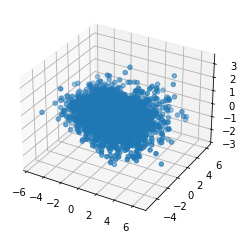

In [34]:

RS = 20150101
pca = PCA(random_state=RS)
pca3d = pca.fit_transform(zs.reshape(zs.shape[0],-1)) 
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pca3d[:,0],pca3d[:,1],pca3d[:,2])


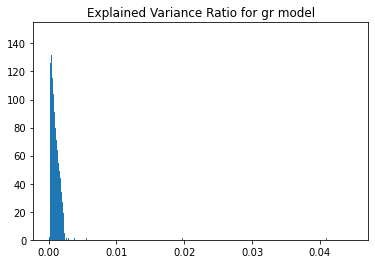

In [36]:
plt.hist(pca.explained_variance_ratio_,bins=np.arange(0.0,0.045,step=0.00015))
plt.ylim(0,155)
plt.title('Explained Variance Ratio for gr model')
plt.savefig('../img/pca_gr/var_ratio')

# bins for different pcs for 2 dims

In [278]:
bins = 5
interpols = []
pca_comps = 5
for i in range(pca_comps): # first 4 pcs
    r1,r2 = np.min(pca3d[:,i]), np.max(pca3d[:,i])
    
    bins1 = np.arange(r1,r2, step=(r2-r1)/bins)
    bin_i = np.digitize(pca3d[:,i],bins=bins1) # which light curve belongs to which bin? 
    
    # average light curves across bins 
    avgs = [np.concatenate((zs[bin_i==i].mean(0)[np.newaxis],disc_path[bin_i==i].mean(0)[np.newaxis]), axis=0) \
     for i in range(1,bins+1)]
    
    avgs = np.array(avgs,dtype=np.float32)
    #print(avgs.shape)
    target_tp = np.arange(0,1500,step=2.5, dtype=np.float32)
    target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(len(bins1),axis=0)
    interps = utils.decode(net,zs=avgs[:,0],disc_path=avgs[:,1],target_x=target_tp,device='mps', batch_size=2)
    
    interpols.append(interps)
    


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 11.98it/s]


In [279]:
avgs[:,0].shape

(5, 16, 64)

In [16]:
os.listdir()

['interpols_gr_blend.pkl',
 'interpols_gri.pkl',
 'Untitled.ipynb',
 'interpols_gri_blend.pkl',
 'zs_gr.dat',
 'pca_grid_exp_g.ipynb',
 'interpols.pkl',
 'interpols_gr.pkl',
 'pca_grid_exp_gri.ipynb',
 '.ipynb_checkpoints',
 'pca_grid_exp_gr.ipynb',
 'zs_gri.dat']

In [17]:
import pickle
with open('interpols.pkl', 'rb') as f:
    interpols = pickle.load(f)

In [18]:
interpols[0].shape

(10, 3, 600, 3)

In [281]:
# really ugly code

IndexError: list index out of range

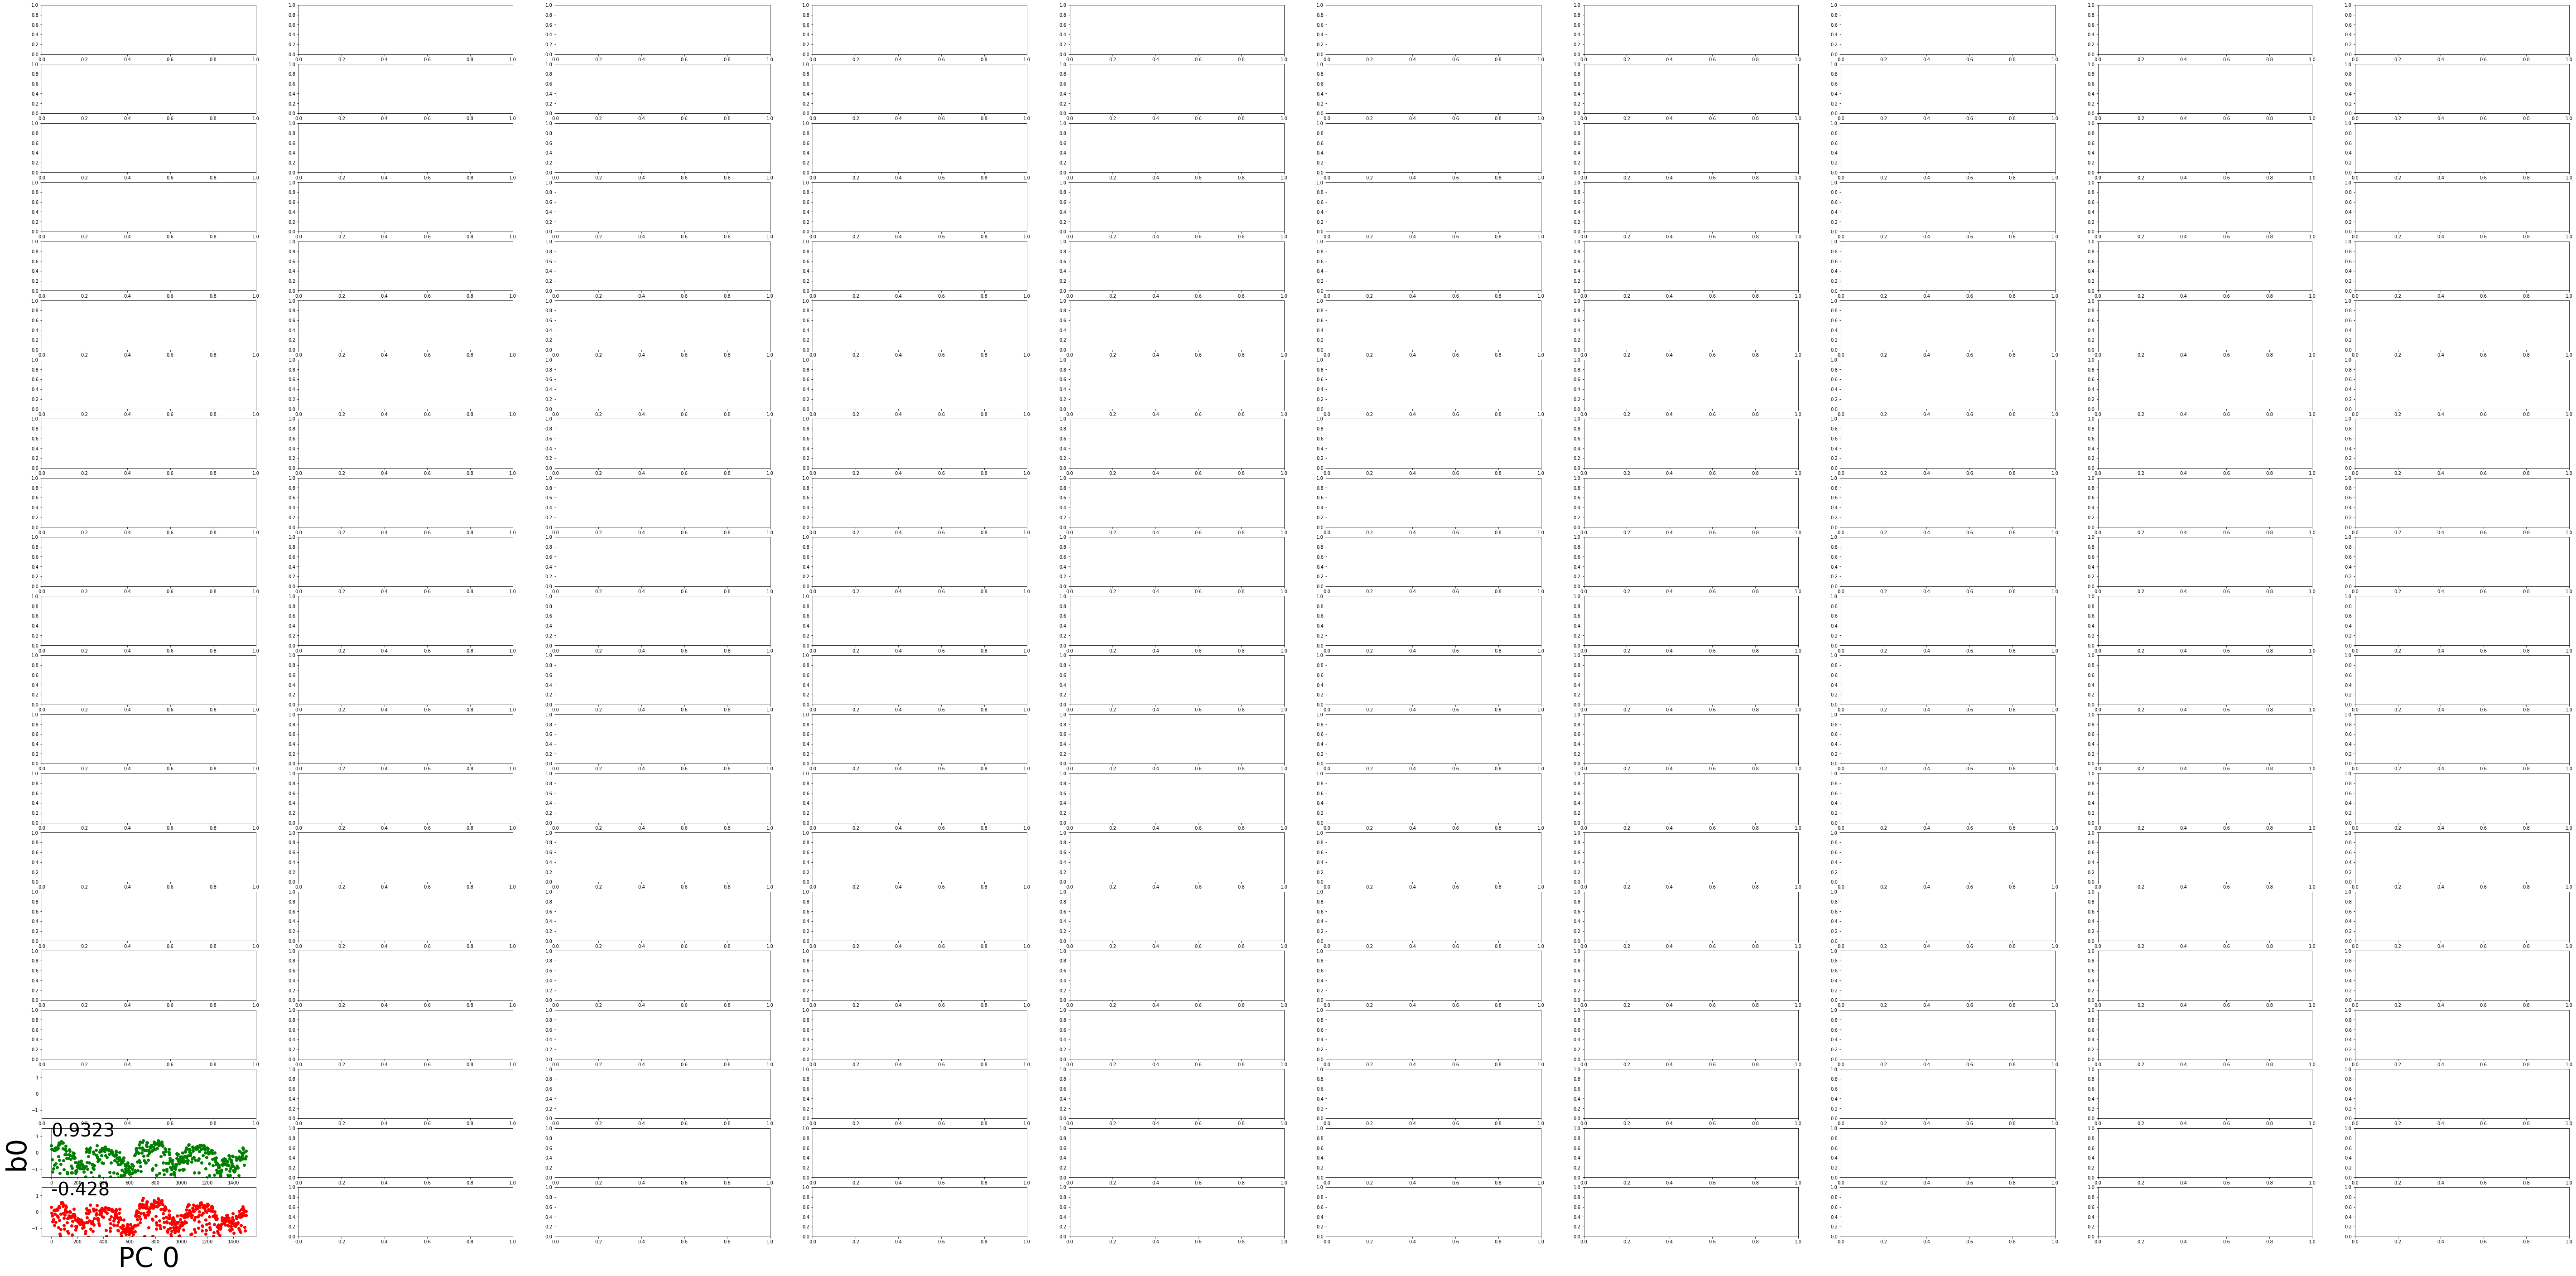

In [10]:
fs = 60
bins=7
pca_comps=10
dims = interpols[0].shape[1]
colors = ['r','g','b']
fig,ax = plt.subplots(bins*dims,pca_comps, figsize=(100,50))
for i in range(pca_comps):
    ax[bins*dims-1,i].set_xlabel(f'PC {i}',fontsize=fs)
    for bin in range(0,bins*dims,2):
        interps = interpols[i]
        ###### labeling #######
        s2s = []
        for dim in range(dims):
            lc = interpols[i][int(bin/2),dim,:,:2]
            s2 = round((1/(len(lc)-1)) * ((lc[:,1] - np.mean(lc[:,1]))**2).sum(),4)
            s2s.append(s2)
        ax[~(bin+1),0].set_ylabel(f'b{int(bin/2)}',fontsize=fs)
        ################
        for dim in range(dims):
            
            ax[~(bin+dim),i].set_ylim(-1.5,1.5)
            ax[~(bin+dim),i].scatter(interps[int(bin/2),dim,:,0], interps[int(bin/2),dim,:,1],c=colors[dim],label=lcs.bands[dim])
            if lcs.bands[dim] == 'r':
                s2 = s2s[0] - s2s[1]
                ax[~(bin+dim),i].text(0,1.0,"{0:+.03f}".format(s2),fontsize=40)
            else:
                s2 = s2s[1]
                ax[~(bin+dim),i].text(0,1.0,s2,fontsize=40)
                ax[~(bin+dim),i].vlines(0,-1.5,-1.5 + s2*10, colors='red')
     

fig.text(0.2,0.42,'g',fontsize=120,color='g')
fig.text(0.25,0.33,'r',fontsize=120,color='r')

plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('../img/pca_gr/recons_uniftp')

 

In [38]:
bins = 7
interpols = []

r1_1,r2_1 = np.min(pca3d[:,0]), np.max(pca3d[:,0])
r1_2,r2_2 = np.min(pca3d[:,1]), np.max(pca3d[:,1])

bins1 = np.arange(r1_1,r2_1, step=(r2_1-r1_1)/bins)
bins2 = np.arange(r1_2,r2_2, step=(r2_2-r1_2)/bins)

in_which_1 = np.digitize(pca3d[:,0],bins=bins1) - 1
in_which_2 = np.digitize(pca3d[:,1],bins=bins2) - 1 
# avgs= []
# for i in range(bins):
#     for j in range(bins):
#         #print(np.logical_and(in_which_1==i,in_which_2==j).sum())
#         avg = np.concatenate((zs[np.logical_and(in_which_1==i,in_which_2==j)].mean(0)[np.newaxis], \
#                                 disc_path[np.logical_and(in_which_1==i,in_which_2==j)].mean(0)[np.newaxis]),\
#                                axis=0)
#         avgs.append(avg)
        
# avgs = np.array(avgs,dtype=np.float32)
# target_tp = np.arange(0,1500,step=2.5, dtype=np.float32)
# target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(bins**2,axis=0)
# # interps = utils.decode(net,zs=avgs[:,0],disc_path=avgs[:,1],target_x=target_tp,device='mps', batch_size=2)


In [26]:
intrps.shape

(49, 2, 600, 3)

In [27]:
import pickle
with open('interpols_gr_blend.pkl', 'rb') as f:
    interps = pickle.load(f)

In [28]:
intrps.shape
bins=7

In [29]:
interps = interps.reshape(bins,bins,interps.shape[1],interps.shape[2],interps.shape[3])

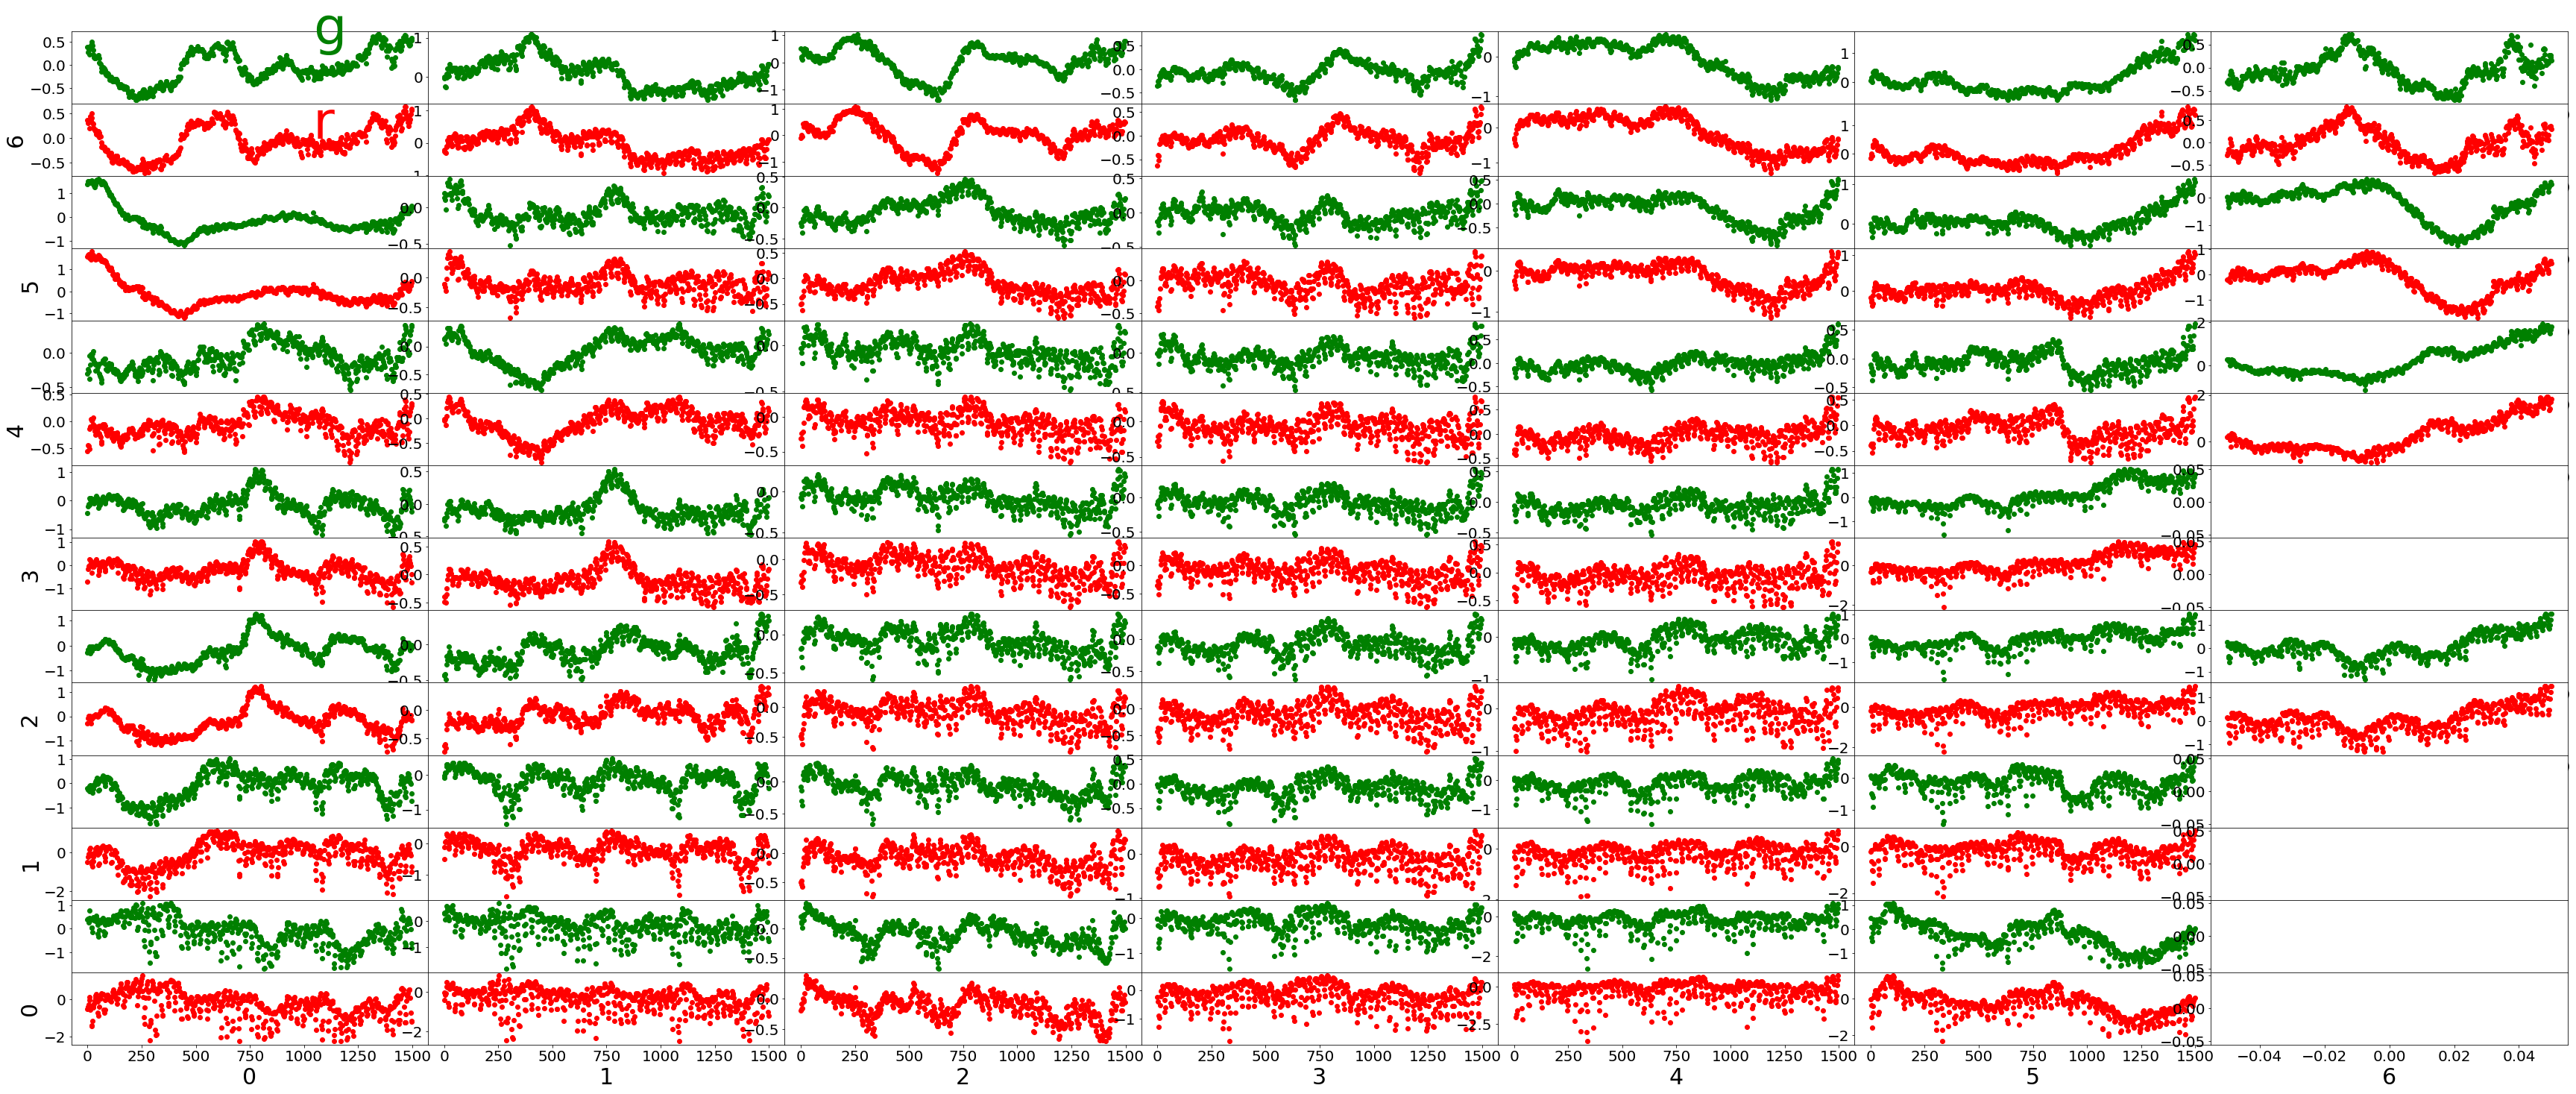

In [91]:
dims = len(lcs.bands)
fs=30
fig,ax = plt.subplots(bins*2,bins,figsize=(60,25))
for i in range(0,bins*2, 2):
    ax[~i,0].set_ylabel(int(i/2),fontsize=fs)
    for j in range(bins):
        ax[~0,j].set_xlabel(j,fontsize=fs)
        for dim in range(dims):
            ax[~(i+dim),j].scatter(interps[int(i/2),j,dim,:,0], interps[int(i/2),j,dim,:,1],c=colors[dim])
            
fig.text(0.2,0.87,'g',fontsize=70,color='g')
fig.text(0.2,0.80,'r',fontsize=70,color='r')
# ax[1,0].text(0,0,'r',c='r',fontsize=100)
plt.subplots_adjust(wspace=0, hspace=0)     
# plt.savefig('../img/pca_gr/recons_blend')

In [89]:
np.unique(in_which_1)

array([0, 1, 2, 3, 4, 5, 6])

# GET light curves from a given bin

In [95]:
indys = []
for gimme_bin in [(6,4)]:
    lc_indexes = np.where([np.logical_and(in_which_1==gimme_bin[0], in_which_2==gimme_bin[1])])[1]
    print(lcs.valid_files_df.index[[lc_indexes]], lc_indexes)
    indys.append(lc_indexes)

Index(['003844.87-004404.5', '092451.62+451639.6', '080012.99+221540.2',
       '234657.08+004518.8', '134532.23+384541.4', '005828.14+242000.1',
       '122440.02+580854.5', '104426.81+321502.0'],
      dtype='object') [ 341 1082 1085 1899 2023 2097 2235 2379]


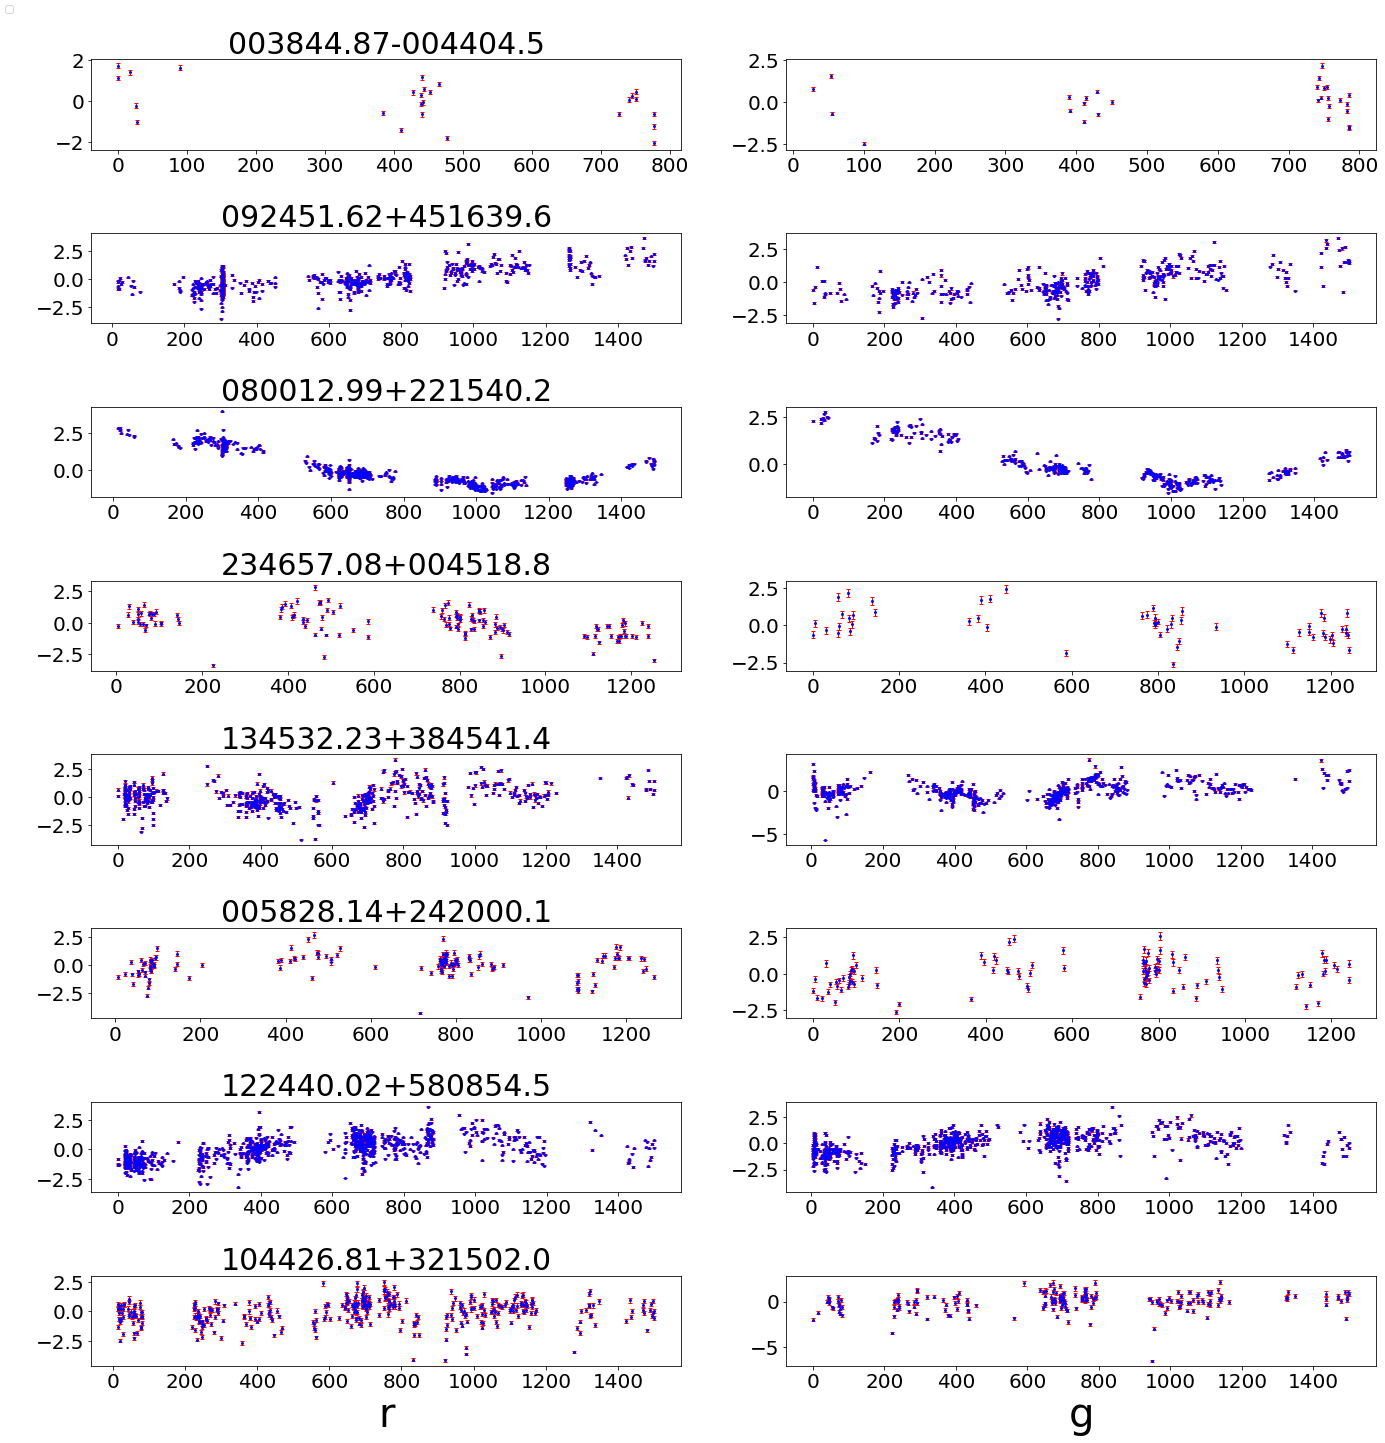

In [99]:
utils.preview_lcs(lcs, indexes=indys[0], figsize=(20,20), fs=30,save=False, filepath='../img/filtered_lcs/bin65')